In [ ]:
!unzip /content/webnlg-dataset-master-release_v3.0-en.zip -d /content/

Archive:  /content/webnlg-dataset-master-release_v3.0-en.zip
587fa698bec705efbefe72a235a6019c2b9b8b6c
   creating: /content/webnlg-dataset-master-release_v3.0-en/
   creating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/
   creating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/
   creating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/
   creating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/1triples/
  inflating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/1triples/Airport_allSolutions.xml  
  inflating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/1triples/Artist_allSolutions.xml  
  inflating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/1triples/Astronaut_allSolutions.xml  
  inflating: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/1triples/Athlete_allSolutions.xml  
  inflating: /content/webnlg-dataset-master-releas

In [ ]:
!git clone https://github.com/WebNLG/webnlg_toolkit.git

Cloning into 'webnlg_toolkit'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 230 (delta 45), reused 211 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (230/230), 16.78 MiB | 32.61 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
%cd webnlg_toolkit

/content/webnlg_toolkit


In [ ]:
%ls

LICENSE  README.md  requirements.txt  setup.py  webnlg_toolkit/


In [ ]:
!pip install -e .

Obtaining file:///content/webnlg_toolkit
  Preparing metadata (setup.py) ... done
  Running setup.py develop for webnlg_toolkit


In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import torch
import re
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AdamW,
    get_linear_schedule_with_warmup
)
!pip install datasets
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import webnlg_toolkit
from webnlg_toolkit.utils.data import load_webnlg_dataset
from webnlg_toolkit.utils.data import load_webnlg_xml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 37.1 MB/s eta 0:00:00


In [ ]:
# Define paths
#dataset_root = "/content/drive/MyDrive/en/train/"
#test_root = "/content/drive/MyDrive/en/dev/"

dataset_root = "/content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/"
test_root = "/content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/"

# Function to find dataset files
def find_dataset_files(root_folder, file_extension=".xml"):
    dataset_files = []
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(file_extension):
                dataset_files.append(os.path.join(subdir, file))
    return dataset_files

# Load training data
def load_all_data(root_folder):
    dataset_files = find_dataset_files(root_folder, file_extension=".xml")
    all_data = []
    for file in dataset_files:
        print(f"Loading: {file}")
        data = load_webnlg_dataset(file, task="rdf2text")
        all_data.extend(data)
    return all_data

# Load training and test data
train_data = load_all_data(dataset_root)
test_data = load_all_data(test_root)

# Convert to DataFrames
train_df = pd.DataFrame(train_data, columns=["input", "output"])
test_df = pd.DataFrame(test_data, columns=["input", "output"])
print(f"Training examples: {len(train_df)}")
print(f"Test examples: {len(test_df)}")

# Display some examples
print("\nTraining examples:")
print(train_df.head(3))

print("\nTest examples:")
print(test_df.head(3))

Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/7triples/Astronaut.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/7triples/Company.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/7triples/Monument.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/7triples/University.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/3triples/CelestialBody.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/3triples/Airport.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/3triples/Astronaut.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/3triples/Building.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/3triples/Athlete.xml
Loading: /content/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/3triples/Food.xm

In [ ]:
def extract_relations(input_text):
    """Extract relation types from input text in the format <S> entity1 <P> relation <O> entity2"""
    relations = []
    pattern = r'<P>\s+(.*?)\s+<O>'
    matches = re.findall(pattern, input_text)
    return matches

# Apply relation extraction to create a new column with relation types
train_df['relations'] = train_df['input'].apply(extract_relations)
test_df['relations'] = test_df['input'].apply(extract_relations)


In [ ]:
def extract_entities(input_text):
    """Extract entity pairs from input text in the format <S> entity1 <P> relation <O> entity2"""
    entity_pairs = []
    pattern = r'<S>\s+(.*?)\s+<P>.*?<O>\s+(.*?)(?:\n|$)'
    matches = re.findall(pattern, input_text)
    return matches

# Apply entity extraction to create a new column with entity pairs
train_df['entity_pairs'] = train_df['input'].apply(extract_entities)
test_df['entity_pairs'] = test_df['input'].apply(extract_entities)


In [ ]:
all_relations = []
for relations in train_df['relations']:
    all_relations.extend(relations)
unique_relations = sorted(list(set(all_relations)))
relation_to_id = {relation: idx for idx, relation in enumerate(unique_relations)}
id_to_relation = {idx: relation for relation, idx in relation_to_id.items()}

print(f"\nNumber of unique relation types: {len(unique_relations)}")
print("Example relation types:", unique_relations[:5])


Number of unique relation types: 372
Example relation types: ['1st runway length feet', '1st runway length metre', '1st runway number', '1st runway surface type', '2nd runway surface type']


In [ ]:
class RelationExtractionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, relation_to_id=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.relation_to_id = relation_to_id

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        input_text = row['input']
        output_text = row['output']

        # For simplicity, we'll use the first relation in each example
        relation = row['relations'][0] if len(row['relations']) > 0 else "unknown"
        entity_pair = row['entity_pairs'][0] if len(row['entity_pairs']) > 0 else ("", "")

        # Create input for BERT: [CLS] entity1 [SEP] entity2 [SEP]
        entity1, entity2 = entity_pair
        encoding = self.tokenizer(
            entity1,
            entity2,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove batch dimension
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}

        # Add relation label
        if self.relation_to_id:
            relation_id = self.relation_to_id.get(relation, 0)  # Default to 0 if relation not found
            encoding['labels'] = torch.tensor(relation_id, dtype=torch.long)

        return encoding

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Create datasets
train_dataset = RelationExtractionDataset(train_df, tokenizer, relation_to_id=relation_to_id)
test_dataset = RelationExtractionDataset(test_df, tokenizer, relation_to_id=relation_to_id)

# Split training data into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"\nTraining set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")



Training set size: 31883
Validation set size: 3543
Test set size: 4464


In [ ]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_relations)
)

# Set up training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of training epochs
num_epochs = 3
total_steps = len(train_loader) * num_epochs

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    return total_loss / len(dataloader)

In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)

            total_loss += loss.item()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(dataloader), accuracy, f1, all_preds, all_labels

In [ ]:
# Training loop
print("\nStarting training...")
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_loss, val_accuracy, val_f1, _, _ = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f"Train loss: {train_loss:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 score: {val_f1:.4f}")


Starting training...

Epoch 1/3


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 2.2688
Validation loss: 1.0472
Validation accuracy: 0.8431
Validation F1 score: 0.7979

Epoch 2/3


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.8005
Validation loss: 0.5997
Validation accuracy: 0.9083
Validation F1 score: 0.8814

Epoch 3/3


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.5361
Validation loss: 0.4999
Validation accuracy: 0.9173
Validation F1 score: 0.8927



Model saved to /content/bert_relation_extraction.pt


Text(0.5, 0, 'Epoch')

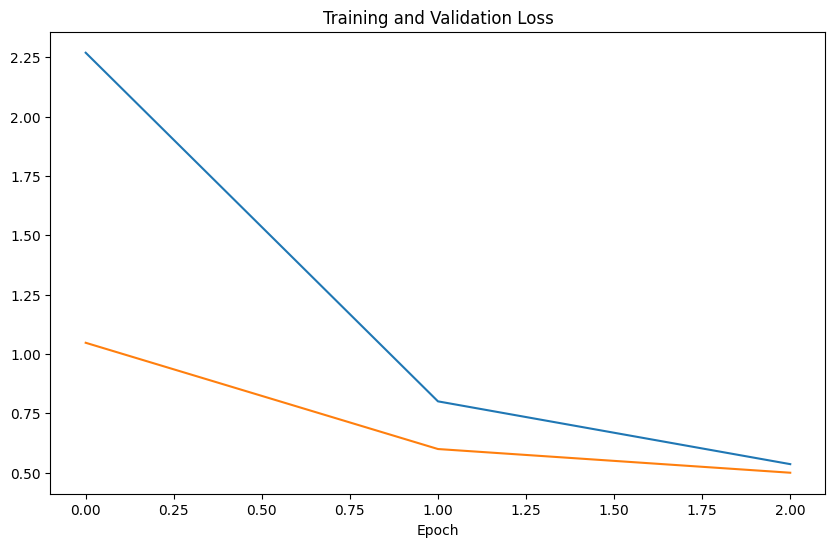

In [ ]:
# Save the model
model_save_path = "/content/bert_relation_extraction.pt"
torch.save(model.state_dict(), model_save_path)
print(f"\nModel saved to {model_save_path}")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

***********************************************************************************************

In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [ ]:
import webnlg_toolkit
from webnlg_toolkit.utils.data import load_webnlg_dataset
from webnlg_toolkit.utils.data import load_webnlg_xml

In [ ]:
dataset_root= "/content/drive/MyDrive/en/train/"
def find_dataset_files(root_folder, file_extension=".xml"):
    dataset_files = []
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(file_extension): #and "en" in file:  # Filter for English files
                dataset_files.append(os.path.join(subdir, file))
    return dataset_files

# Get all relevant files (change extension if needed)
dataset_files = find_dataset_files(dataset_root, file_extension=".xml")

# Load all dataset parts
all_data = []
for file in dataset_files:
    print(f"Loading: {file}")
    data = load_webnlg_dataset(file, task="rdf2text")
    all_data.extend(data)

# Print first few loaded entries to verify
print(all_data[:5])


Loading: /content/drive/MyDrive/en/train/6triples/Company.xml
Loading: /content/drive/MyDrive/en/train/6triples/Monument.xml
Loading: /content/drive/MyDrive/en/train/6triples/University.xml
Loading: /content/drive/MyDrive/en/train/6triples/Astronaut.xml
Loading: /content/drive/MyDrive/en/train/2triples/Building.xml
Loading: /content/drive/MyDrive/en/train/2triples/Airport.xml
Loading: /content/drive/MyDrive/en/train/2triples/ComicsCharacter.xml
Loading: /content/drive/MyDrive/en/train/2triples/Artist.xml
Loading: /content/drive/MyDrive/en/train/2triples/WrittenWork.xml
Loading: /content/drive/MyDrive/en/train/2triples/Food.xml
Loading: /content/drive/MyDrive/en/train/2triples/CelestialBody.xml
Loading: /content/drive/MyDrive/en/train/2triples/City.xml
Loading: /content/drive/MyDrive/en/train/2triples/University.xml
Loading: /content/drive/MyDrive/en/train/2triples/Astronaut.xml
Loading: /content/drive/MyDrive/en/train/2triples/MeanOfTransportation.xml
Loading: /content/drive/MyDrive/en

In [ ]:
print(type(all_data))
print(all_data[0])

<class 'list'>
('<S> AmeriGas <P> region served <O> United States\n<S> AmeriGas <P> city <O> King of Prussia, Pennsylvania\n<S> AmeriGas <P> operating income <O> 380700000\n<S> AmeriGas <P> industry <O> Energy industry\n<S> AmeriGas <P> country <O> United States\n<S> AmeriGas <P> founding date <O> 1959-01-01', 'AmeriGas (founded on January 01, 1959) is located in King of Prussia, Pennsylvania and works as well as provides its services in the United States. It is in the energy industry, and has an operating income of $380,700,000.')


In [ ]:
df = pd.DataFrame(all_data, columns=["input", "output"])

# Display some samples
print(df.head())

                                               input  \
0  <S> AmeriGas <P> region served <O> United Stat...   
1  <S> AmeriGas <P> region served <O> United Stat...   
2  <S> AmeriGas <P> region served <O> United Stat...   
3  <S> AmeriGas <P> region served <O> United Stat...   
4  <S> AmeriGas <P> region served <O> United Stat...   

                                              output  
0  AmeriGas (founded on January 01, 1959) is loca...  
1  Serving all regions of the United States, Amer...  
2  AmeriGas (founded on January 01, 1959) is loca...  
3  AmeriGas, located in King of Prussia, Pennsylv...  
4  Located in King of Prussia, Pennsylvania in th...  


In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["input"], example["output"], padding="max_length", truncation=True, max_length=512)

# Convert Pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Tokenize dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

AttributeError: type object 'Dataset' has no attribute 'from_pandas'